In [1]:
%matplotlib inline
import numpy as np                                
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns
plt.rcParams['figure.figsize'] = (6,6)

import util
from util import df_with_selected_features, split_df, split_df_to_x_y, train_model_func

import spacy

In [2]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.layers.merge import add
from keras.optimizers import SGD , Adam
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils
from keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report

import os

Using TensorFlow backend.


In [3]:
#! pip install -U spacy

In [4]:
#! python -m spacy download en_core_web_md

In [5]:
df = util.read_df('data/messages.csv')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
df.head(1)

,Unnamed: 0,InBoundCreatedAT,InBound,OutBound,TemplateID,TemplateMessage,TemplateStoreID,ConversationID,StoreID,ConversationType,ConversationLength,PreviousMessages,label,body,outbound_tokens,template_tokens,template_distance
0,2,2019-03-20 19:04:51,What is this logo??,"This number was set up for SMS messaging only,...",1150.0,"This number was set up for SMS messaging only,...",0.0,1169417.0,189.0,1.0,9.0,What is this logo??;received||\nI don't have a...,__label__1150,what is this logo,"['this', 'number', 'was', 'set', 'up', 'for', ...","['this', 'number', 'was', 'set', 'up', 'for', ...",0.275862


In [7]:
df = df[['InBound', 'TemplateID', 'ConversationType', 'ConversationLength']]

### Merge some groups
df['TemplateID'] = np.where(df['TemplateID'].isin([321,5617, 718]), 321, df['TemplateID'])
df['TemplateID'] = np.where(df['TemplateID'].isin([6651, 5244]), 5244, df['TemplateID'])


In [8]:
import en_core_web_md
nlp = en_core_web_md.load()
#nlp = spacy.load('en_core_web_md')

In [9]:
#Clean text
tokens = df['InBound'].apply(util.spacy_tokenizer)
df['InBoundClean'] = tokens.apply(' '.join)

# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.InBoundClean)
X = tokenizer.texts_to_sequences(df.InBoundClean)
df['InBoundWords'] = X


df['InBoundLength'] = df.InBoundWords.apply(lambda i: len(i))


df.head(1)

,InBound,TemplateID,ConversationType,ConversationLength,InBoundClean,InBoundWords,InBoundLength
0,What is this logo??,1150.0,1.0,9.0,logo,[1649],1


In [10]:
df.InBoundLength.describe()

count    268880.000000
mean          3.910484
std           4.387880
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         250.000000
Name: InBoundLength, dtype: float64

In [11]:
# using 30 for padding length
maxlen = 30
X = list(sequence.pad_sequences(df.InBoundWords, maxlen=maxlen))

In [12]:
#GolVe Embedding

word_index = tokenizer.word_index

EMBEDDING_DIM = 300

embeddings_index = {}

for word , idx in word_index.items():
    try:
        embedding = nlp(word).vector
        embeddings_index[word] = embedding
    except:
        pass

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 24620 unique tokens.
Total 24620 word vectors.


In [13]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

In [14]:
# category to id

categories = df.groupby('TemplateID').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['Class'] = df['TemplateID'].apply(lambda x: category_int[x])


In [15]:
X_feat = df[['ConversationType', 'ConversationLength']]
cat_feat = pd.get_dummies(X_feat['ConversationType'] )
X_feat.head()

,ConversationType,ConversationLength
0,1.0,9.0
1,1.0,27.0
2,3.0,2.0
3,2.0,3.0
4,3.0,2.0


In [16]:
X_feat = np.array(df[['ConversationType', 'ConversationLength']])
cat_feats = 'ConversationType'
cat_feats_name=['cart', 'live_text', 'campaigns', 'platform', 'optin_disc',
                                               'optin_conf']
cat_f = pd.get_dummies(df[cat_feats])
if cat_feats_name is not None:
    cat_f.columns = cat_feats_name
X_feat = pd.concat([df['ConversationLength'], cat_f], axis=1)
X_feat.head()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_feat = sc.fit_transform(X_feat)


In [17]:
X_feat.shape

(268880, 7)

In [49]:
def train_val_plots(model_history):

    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')
    plt.legend()

    plt.show()

In [57]:
def predition_result(model, x ,y, confusion_mtx = False):


    predicted = model.predict(x)

    report = classification_report(y.argmax(axis=1), predicted.argmax(axis=1) , output_dict= True)
    print(classification_report(y.argmax(axis=1), predicted.argmax(axis=1) , output_dict= False))
    df_report = pd.DataFrame(report).transpose()

    if confusion_mtx:
        cm = pd.DataFrame(confusion_matrix(y.argmax(axis=1), predicted.argmax(axis=1)))

        plt.figure(figsize = (15,15))
        sns.heatmap(cm, annot=True , fmt = 'd', cmap = 'PuRd')
        tick_marks = np.arange(len(cm))

        plt.show()
    
    
    values = df_report['precision'][:-3]
    x_axis = range(len(values))
    threshold =0.5
    above_threshold = np.maximum(values - threshold, 0)
    below_threshold = np.minimum(values, threshold)

    plt.figure(figsize = (10, 4))
    plt.bar(x_axis, below_threshold, 0.35, color="darkblue")
    plt.bar(x_axis, above_threshold, 0.35, color="green",
            bottom=below_threshold)

    # horizontal line indicating the threshold
    plt.plot([-.5, 23.5], [threshold, threshold], "k--")

    plt.xticks(ticks= np.arange(len(df_report.index[:-3])) ,labels = df_report.index[:-3], rotation=45)
    plt.show()

    return df_report

In [18]:
#Split Data

X = np.array(X)
Y = np_utils.to_categorical(list(df.Class))

# and split to training set and validation set

seed = 42
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)
x_train_meta, x_val_meta = train_test_split(X_feat, test_size=0.2, random_state=seed)

## 1D CNN

In [19]:
# 1D CNN

inp = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(len(int_category), activation='softmax')(drop)

TextCNN = Model(inputs=inp, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 300)      7386300     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 30, 64)       38464       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)    

In [20]:
early_stopping_monitor = EarlyStopping(patience=3)

textcnn_history = TextCNN.fit(x_train, 
                              y_train, 
                              batch_size=32, 
                              epochs=20, 
                              validation_split=0.3,
                              #validation_data=(x_val, y_val)
                             callbacks=[early_stopping_monitor])

Instructions for updating:
Use tf.cast instead.
Train on 150572 samples, validate on 64532 samples
Epoch 1/20
150572/150572 [==============================] - 111s 738us/step - loss: 0.8555 - acc: 0.7826 - val_loss: 0.6483 - val_acc: 0.8249
Epoch 2/20
150572/150572 [==============================] - 107s 708us/step - loss: 0.7568 - acc: 0.8041 - val_loss: 0.6366 - val_acc: 0.8277
Epoch 3/20
150572/150572 [==============================] - 100s 662us/step - loss: 0.7416 - acc: 0.8102 - val_loss: 0.6213 - val_acc: 0.8350
Epoch 4/20
150572/150572 [==============================] - 98s 654us/step - loss: 0.7343 - acc: 0.8111 - val_loss: 0.6248 - val_acc: 0.8327
Epoch 5/20
150572/150572 [==============================] - 99s 654us/step - loss: 0.7285 - acc: 0.8125 - val_loss: 0.6264 - val_acc: 0.8342
Epoch 6/20
150572/150572 [==============================] - 108s 715us/step - loss: 0.7240 - acc: 0.8146 - val_loss: 0.6271 - val_acc: 0.8326


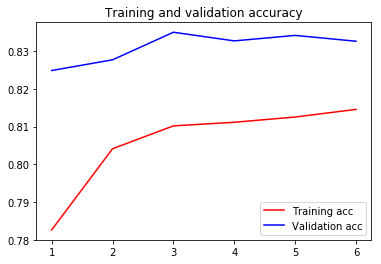

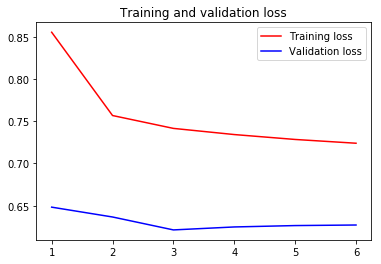

In [22]:
train_val_plots(model_history = textcnn_history)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score a

              precision    recall  f1-score   support

           0       0.69      0.49      0.57       538
           1       0.00      0.00      0.00       227
           2       0.95      0.91      0.93      6790
           3       0.85      0.98      0.91     33315
           4       0.85      0.55      0.67      1288
           5       0.66      0.30      0.41       555
           6       0.68      0.63      0.65       631
           7       0.85      0.61      0.71       556
           8       0.00      0.00      0.00       201
           9       0.70      0.58      0.63       349
          10       0.71      0.16      0.27       226
          11       0.78      0.73      0.76      1439
          12       0.67      0.22      0.33       521
          13       0.19      0.01      0.03       805
          14       0.60      0.61      0.60      1390
          15       0.96      0.26      0.40       257
          16       0.75      0.55      0.63       869
          17       0.18    

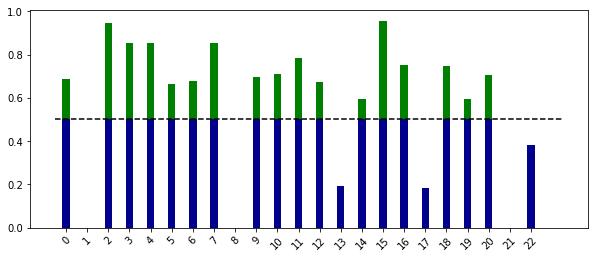

In [26]:
result_cnn = predition_result(TextCNN, x_val ,y_val)

## 1D CNN with meta data

In [27]:
inp = Input(shape=(maxlen,), dtype='int32')
meta_input = Input(shape=(X_feat.shape[1],), name='meta_input')

embedding = embedding_layer(inp)
stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
merged = concatenate([flatten, meta_input])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.5)(merged)

outp = Dense(len(int_category), activation='softmax')(merged)

TextCNNmeta = Model(inputs=[inp,meta_input], outputs=outp)
TextCNNmeta.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 300)      7386300     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 30, 64)       38464       embedding_1[1][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 30, 64)       57664       embedding_1[1][0]                
__________________________________________________________________________________________________
conv1d_6 (

In [28]:
early_stopping_monitor = EarlyStopping(patience=2)

textcnn_with_meta_history = TextCNNmeta.fit([x_train, x_train_meta], 
                              y_train, 
                              batch_size=32, 
                              epochs=10, 
                              validation_split=0.3,
                              #validation_data=([x_val, x_val_meta], y_val),
                             callbacks=[early_stopping_monitor])

Train on 150572 samples, validate on 64532 samples
Epoch 1/10
150572/150572 [==============================] - 121s 807us/step - loss: 0.8273 - acc: 0.7842 - val_loss: 0.6173 - val_acc: 0.8267
Epoch 2/10
150572/150572 [==============================] - 119s 788us/step - loss: 0.6954 - acc: 0.8135 - val_loss: 0.5898 - val_acc: 0.8357
Epoch 3/10
150572/150572 [==============================] - 120s 796us/step - loss: 0.6620 - acc: 0.8208 - val_loss: 0.5681 - val_acc: 0.8378
Epoch 4/10
150572/150572 [==============================] - 122s 807us/step - loss: 0.6433 - acc: 0.8227 - val_loss: 0.5663 - val_acc: 0.8393
Epoch 5/10
150572/150572 [==============================] - 118s 783us/step - loss: 0.6296 - acc: 0.8266 - val_loss: 0.5556 - val_acc: 0.8418
Epoch 6/10
150572/150572 [==============================] - 120s 799us/step - loss: 0.6196 - acc: 0.8299 - val_loss: 0.5504 - val_acc: 0.8439
Epoch 7/10
150572/150572 [==============================] - 120s 795us/step - loss: 0.6083 - acc:

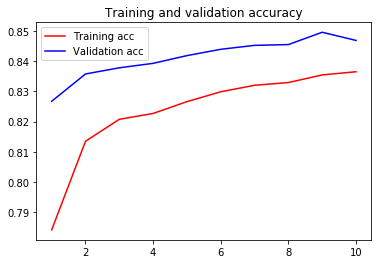

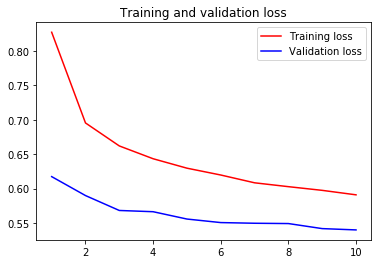

In [51]:
train_val_plots(model_history = textcnn_with_meta_history)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score a

              precision    recall  f1-score   support

           0       0.52      0.60      0.56       538
           1       0.64      0.03      0.06       227
           2       0.95      0.93      0.94      6790
           3       0.88      0.98      0.93     33315
           4       0.85      0.64      0.73      1288
           5       0.55      0.18      0.27       555
           6       0.56      0.73      0.63       631
           7       0.85      0.66      0.74       556
           8       0.00      0.00      0.00       201
           9       0.74      0.63      0.68       349
          10       0.73      0.08      0.15       226
          11       0.83      0.74      0.78      1439
          12       0.64      0.29      0.40       521
          13       0.00      0.00      0.00       805
          14       0.70      0.64      0.67      1390
          15       0.71      0.38      0.50       257
          16       0.62      0.70      0.66       869
          17       0.26    

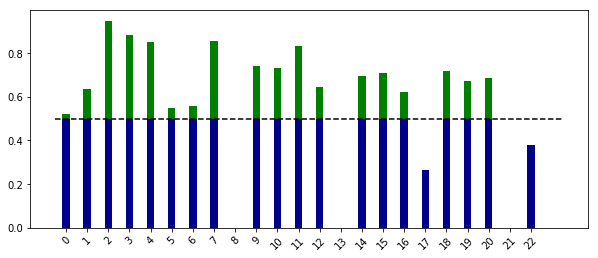

In [31]:
result_cnn_with_meta = predition_result(TextCNNmeta, [x_val, x_val_meta] ,y_val)

## LSTM

In [36]:
Lstm = Sequential()

inp = Input(shape=(maxlen,), dtype='int32')
Lstm.add(embedding_layer)
Lstm.add(LSTM(300, dropout = 0.3))
Lstm.add(Dense(len(int_category), activation='softmax'))
Lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           7386300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_4 (Dense)              (None, 23)                6923      
Total params: 8,114,423
Trainable params: 728,123
Non-trainable params: 7,386,300
_________________________________________________________________


In [37]:
early_stopping_monitor = EarlyStopping(patience=3)

lstm_history = Lstm.fit(x_train, 
                              y_train, 
                              batch_size=32, 
                              epochs=20, 
                              validation_split=0.3,
                        callbacks=[early_stopping_monitor])

Train on 150572 samples, validate on 64532 samples
Epoch 1/20
150572/150572 [==============================] - 583s 4ms/step - loss: 0.6541 - acc: 0.8228 - val_loss: 0.5726 - val_acc: 0.8407
Epoch 2/20
150572/150572 [==============================] - 584s 4ms/step - loss: 0.5362 - acc: 0.8499 - val_loss: 0.5442 - val_acc: 0.8474
Epoch 3/20
150572/150572 [==============================] - 591s 4ms/step - loss: 0.4893 - acc: 0.8609 - val_loss: 0.5413 - val_acc: 0.8497
Epoch 4/20
150572/150572 [==============================] - 591s 4ms/step - loss: 0.4512 - acc: 0.8697 - val_loss: 0.5430 - val_acc: 0.8507
Epoch 5/20
150572/150572 [==============================] - 577s 4ms/step - loss: 0.4169 - acc: 0.8784 - val_loss: 0.5620 - val_acc: 0.8502
Epoch 6/20
150572/150572 [==============================] - 594s 4ms/step - loss: 0.3860 - acc: 0.8869 - val_loss: 0.5746 - val_acc: 0.8475


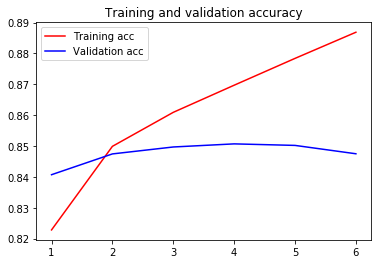

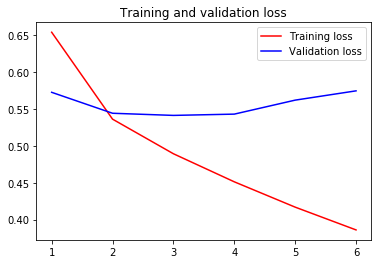

In [52]:
train_val_plots(model_history = lstm_history)

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       538
           1       0.34      0.20      0.25       227
           2       0.94      0.93      0.93      6790
           3       0.91      0.96      0.94     33315
           4       0.76      0.61      0.68      1288
           5       0.55      0.50      0.53       555
           6       0.68      0.62      0.65       631
           7       0.76      0.74      0.75       556
           8       0.25      0.05      0.09       201
           9       0.60      0.73      0.66       349
          10       0.61      0.43      0.50       226
          11       0.76      0.78      0.77      1439
          12       0.54      0.35      0.42       521
          13       0.26      0.12      0.16       805
          14       0.65      0.64      0.65      1390
          15       0.67      0.50      0.57       257
          16       0.56      0.76      0.64       869
          17       0.25    

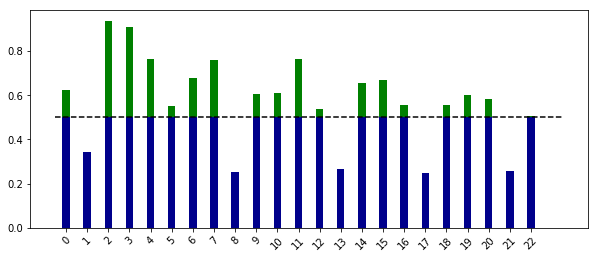

In [41]:
result_lstm = predition_result(Lstm, x_val ,y_val)

## LSTM with Attention

In [44]:
# from https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043/code

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    

lstm_layer = LSTM(300, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)

inp = Input(shape=(maxlen,), dtype='int32', name='text_input')
meta_input = Input(shape=(X_feat.shape[1],), name='meta_input')

embedding= embedding_layer(inp)
x = lstm_layer(embedding)
x = Dropout(0.25)(x)
merged = Attention(maxlen)(x)

merged = concatenate([merged, meta_input])

merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.25)(merged)
merged = BatchNormalization()(merged)
outp = Dense(len(int_category), activation='softmax')(merged)

AttentionLSTM = Model(inputs=[inp, meta_input], outputs=outp)
AttentionLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

AttentionLSTM.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 300)      7386300     text_input[0][0]                 
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 30, 300)      721200      embedding_1[6][0]                
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 30, 300)      0           lstm_3[0][0]                     
__________________________________________________________________________________________________
attention_

In [45]:
early_stopping_monitor = EarlyStopping(patience=3)

attlstm_history = AttentionLSTM.fit([x_train, x_train_meta], 
                                    y_train, 
                                    batch_size=64, 
                                    epochs= 20, 
                                    validation_split=0.3,
                                   callbacks=[early_stopping_monitor])

Train on 150572 samples, validate on 64532 samples
Epoch 1/20
150572/150572 [==============================] - 465s 3ms/step - loss: 0.7828 - acc: 0.7987 - val_loss: 0.5684 - val_acc: 0.8384
Epoch 2/20
150572/150572 [==============================] - 460s 3ms/step - loss: 0.5862 - acc: 0.8364 - val_loss: 0.5213 - val_acc: 0.8485
Epoch 3/20
150572/150572 [==============================] - 460s 3ms/step - loss: 0.5422 - acc: 0.8478 - val_loss: 0.4984 - val_acc: 0.8553
Epoch 4/20
150572/150572 [==============================] - 459s 3ms/step - loss: 0.5180 - acc: 0.8528 - val_loss: 0.4957 - val_acc: 0.8569
Epoch 5/20
150572/150572 [==============================] - 461s 3ms/step - loss: 0.4979 - acc: 0.8579 - val_loss: 0.4870 - val_acc: 0.8586
Epoch 6/20
150572/150572 [==============================] - 461s 3ms/step - loss: 0.4820 - acc: 0.8621 - val_loss: 0.4819 - val_acc: 0.8602
Epoch 7/20
150572/150572 [==============================] - 459s 3ms/step - loss: 0.4685 - acc: 0.8647 - val_

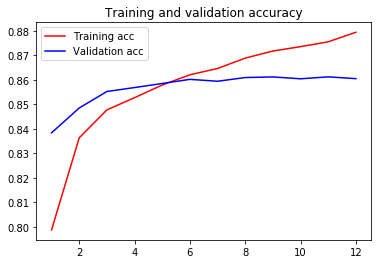

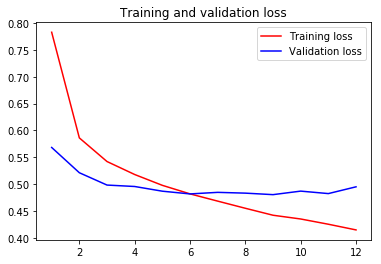

In [53]:
train_val_plots(model_history = attlstm_history)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score a

              precision    recall  f1-score   support

           0       0.67      0.55      0.60       538
           1       0.64      0.30      0.41       227
           2       0.96      0.93      0.94      6790
           3       0.90      0.98      0.94     33315
           4       0.85      0.68      0.75      1288
           5       0.58      0.55      0.57       555
           6       0.74      0.66      0.70       631
           7       0.82      0.72      0.77       556
           8       0.23      0.03      0.05       201
           9       0.74      0.68      0.71       349
          10       0.67      0.38      0.49       226
          11       0.83      0.77      0.80      1439
          12       0.60      0.32      0.42       521
          13       0.33      0.12      0.18       805
          14       0.73      0.68      0.70      1390
          15       0.65      0.51      0.57       257
          16       0.62      0.74      0.68       869
          17       0.32    

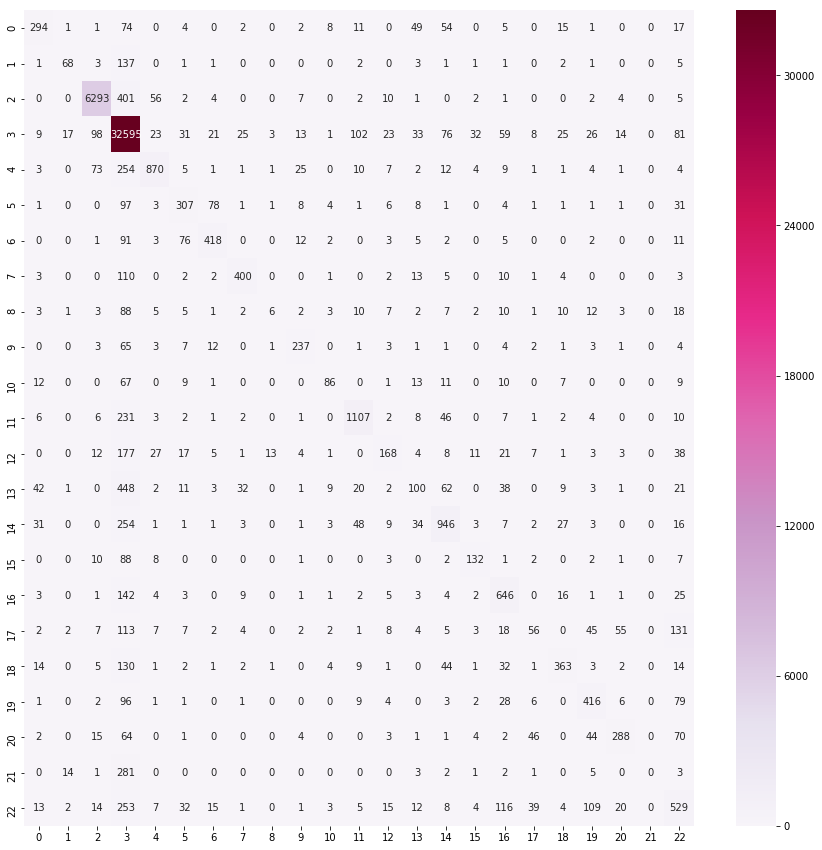

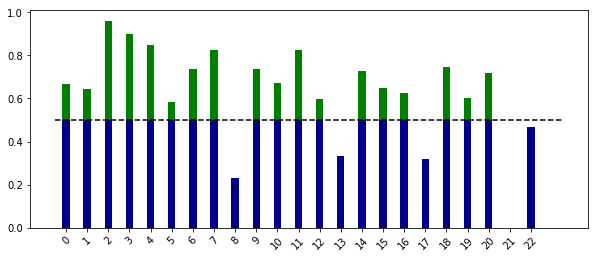

In [61]:
result_attlstm = predition_result(AttentionLSTM, [x_val, x_val_meta] ,y_val, confusion_mtx = True)

In [56]:
# from keras.models import load_model

# AttentionLSTM.save('models/AttentionLSTM.h5')  # creates a HDF5 file 